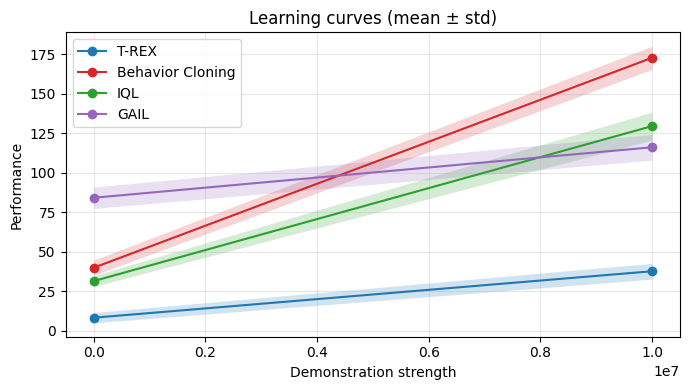

Expert Models:
  TREX: None
  CLASSIFIER_BC: None
  IQL: None
  GAIL: None


In [1]:
import json
import re
import matplotlib.pyplot as plt
import numpy as np

INDEX_PATH = "../../comparison_outputs/index.json"

# Load index
with open(INDEX_PATH, "r") as f:
    index = json.load(f)

# Known algos we want to plot (add more as needed)
ALGOS = ["TREX", "CLASSIFIER_BC", "IQL", "GAIL"]

# Storage
storages = {algo: {"strength": [], "mean": [], "std": []} for algo in ALGOS}

# Expert scores (no numeric suffix)
expert_scores = {algo: None for algo in ALGOS}

# Regex to extract trailing number from filenames
number_regex = re.compile(r".*?_(\d+)\.npz$")

for entry in index:
    algo = entry["algo"]            # e.g. "TREX", "CLASSIFIER_BC", "IQL", "GAIL"
    fname = entry["dataset_name"]   # e.g. "policy_params_6666752.npz"
    reward = entry["avg_reward"]
    std_reward = entry.get("std_reward")

    match = number_regex.match(fname)

    if match is None:
        # Expert model (no number in filename)
        if algo in expert_scores:
            expert_scores[algo] = reward
            print(f"Found expert for {algo}: reward={reward}")
        continue

    # Extract number
    strength = int(match.group(1))

    if algo in storages:
        storages[algo]["strength"].append(strength)
        storages[algo]["mean"].append(reward)
        storages[algo]["std"].append(std_reward if std_reward is not None else 0.0)

# Convert to sorted curves
for algo, data in storages.items():
    sorted_pairs = sorted(zip(data["strength"], data["mean"], data["std"]))
    if sorted_pairs:
        s, m, st = zip(*sorted_pairs)
        storages[algo] = {
            "strength": np.array(s),
            "mean": np.array(m),
            "std": np.array(st),
        }
    else:
        storages[algo] = {"strength": np.array([]), "mean": np.array([]), "std": np.array([])}

# --- Plot ---
plt.figure(figsize=(7, 4))
colors = {
    "TREX": "#1f77b4",          # blue
    "CLASSIFIER_BC": "#d62728", # red
    "IQL": "#2ca02c",           # green
    "GAIL": "#9467bd",          # purple
}
labels = {
    "TREX": "T-REX",
    "CLASSIFIER_BC": "Behavior Cloning",
    "IQL": "IQL",
    "GAIL": "GAIL",
}

for algo, data in storages.items():
    if data["strength"].size == 0:
        continue
    c = colors.get(algo, None)
    plt.plot(data["strength"], data["mean"], marker="o", label=labels.get(algo, algo), color=c)
    plt.fill_between(
        data["strength"],
        data["mean"] - data["std"],
        data["mean"] + data["std"],
        color=c,
        alpha=0.2,
        linewidth=0,
    )

plt.xlabel("Demonstration strength")
plt.ylabel("Performance")
plt.title("Learning curves (mean ± std)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# Print expert scores at the end
print("Expert Models:")
for algo, score in expert_scores.items():
    print(f"  {algo}: {score}")